#### Uber Fares Dataset Analysis - Advanced EDA and Data Cleaning
##### Course: Introduction to Big Data Analytics INSY 8413
###### Assignment I: Power BI Dashboard Development

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from geopy.distance import geodesic
import folium

warnings.filterwarnings('ignore')

In [29]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [12]:
print("="*80)
print("UBER FARES DATASET - ADVANCED EDA AND DATA CLEANING")
print("="*80)
print("\n" + "="*60)
print("1. DATA LOADING AND INITIAL EXPLORATION")
print("="*60)

# Load the dataset
# Replace 'uber_fares.csv' with your actual file path
df = pd.read_csv('../data/uber.csv')
print(f"✓ Dataset loaded successfully!")
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Store original shape for comparison
original_shape = df.shape

UBER FARES DATASET - ADVANCED EDA AND DATA CLEANING

1. DATA LOADING AND INITIAL EXPLORATION
✓ Dataset loaded successfully!
Dataset Shape: 200000 rows, 9 columns
Memory Usage: 42.09 MB


In [13]:
print("\n" + "-"*40)
print("DATASET STRUCTURE AND DIMENSIONS")
print("-"*40)

print(f"Number of Records: {df.shape[0]:,}")
print(f"Number of Features: {df.shape[1]}")
print(f"Total Data Points: {df.shape[0] * df.shape[1]:,}")


----------------------------------------
DATASET STRUCTURE AND DIMENSIONS
----------------------------------------
Number of Records: 200,000
Number of Features: 9
Total Data Points: 1,800,000


In [14]:
# Column information
print(f"\nColumn Names: {list(df.columns)}")


Column Names: ['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [15]:
print("\n" + "-"*40)
print("DATA TYPES AND VARIABLE DESCRIPTIONS")
print("-"*40)

# Create comprehensive data info table
data_info = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Non_Null_Count': df.count(),
    'Null_Count': df.isnull().sum(),
    'Null_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Unique_Values': [df[col].nunique() for col in df.columns],
    'Sample_Values': [str(df[col].dropna().iloc[0]) if not df[col].dropna().empty else 'N/A' for col in df.columns]
})

print(data_info.to_string(index=False))


----------------------------------------
DATA TYPES AND VARIABLE DESCRIPTIONS
----------------------------------------
           Column Data_Type  Non_Null_Count  Null_Count  Null_Percentage  Unique_Values               Sample_Values
       Unnamed: 0     int64          200000           0           0.0000         200000                    24238194
              key    object          200000           0           0.0000         200000 2015-05-07 19:52:06.0000003
      fare_amount   float64          200000           0           0.0000           1244                         7.5
  pickup_datetime    object          200000           0           0.0000         196629     2015-05-07 19:52:06 UTC
 pickup_longitude   float64          200000           0           0.0000          71066          -73.99981689453125
  pickup_latitude   float64          200000           0           0.0000          83835           40.73835372924805
dropoff_longitude   float64          199999           1           0.

In [16]:
# Or with this:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [17]:
print("\n" + "-"*40)
print("INITIAL DATA QUALITY ASSESSMENT")
print("-"*40)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate Records: {duplicates:,} ({(duplicates/len(df))*100:.2f}%)")


----------------------------------------
INITIAL DATA QUALITY ASSESSMENT
----------------------------------------
Duplicate Records: 0 (0.00%)


In [18]:
# Missing values analysis
print(f"\nMissing Values Analysis:")
missing_data = df.isnull().sum()
for col in missing_data.index:
    if missing_data[col] > 0:
        print(f"  {col}: {missing_data[col]:,} missing ({(missing_data[col]/len(df))*100:.2f}%)")


Missing Values Analysis:
  dropoff_longitude: 1 missing (0.00%)
  dropoff_latitude: 1 missing (0.00%)


In [19]:
# Data type issues
print(f"\nData Type Analysis:")
for col, dtype in df.dtypes.items():
    print(f"  {col}: {dtype}")


Data Type Analysis:
  Unnamed: 0: int64
  key: object
  fare_amount: float64
  pickup_datetime: object
  pickup_longitude: float64
  pickup_latitude: float64
  dropoff_longitude: float64
  dropoff_latitude: float64
  passenger_count: int64


In [20]:
print("\n" + "="*60)
print("3. ADVANCED DATA QUALITY CHECKS")
print("="*60)

# Convert pickup_datetime to datetime if it's not already
if df['pickup_datetime'].dtype == 'object':
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Fare Amount Quality Checks
print("-"*40)
print("FARE AMOUNT QUALITY CHECKS")
print("-"*40)

negative_fares = df[df['fare_amount'] < 0].shape[0]
zero_fares = df[df['fare_amount'] == 0].shape[0]
extreme_high_fares = df[df['fare_amount'] > 200].shape[0]
extreme_low_fares = df[df['fare_amount'] < 2.5].shape[0]  # Below minimum NYC taxi fare

print(f"Negative fares: {negative_fares:,} ({(negative_fares/len(df))*100:.2f}%)")
print(f"Zero fares: {zero_fares:,} ({(zero_fares/len(df))*100:.2f}%)")
print(f"Extremely high fares (>$200): {extreme_high_fares:,} ({(extreme_high_fares/len(df))*100:.2f}%)")
print(f"Extremely low fares (<$2.5): {extreme_low_fares:,} ({(extreme_low_fares/len(df))*100:.2f}%)")


3. ADVANCED DATA QUALITY CHECKS
----------------------------------------
FARE AMOUNT QUALITY CHECKS
----------------------------------------
Negative fares: 17 (0.01%)
Zero fares: 5 (0.00%)
Extremely high fares (>$200): 7 (0.00%)
Extremely low fares (<$2.5): 25 (0.01%)


In [21]:
# Fare amount distribution
print(f"\nFare Amount Distribution:")
print(f"  Min: ${df['fare_amount'].min():.2f}")
print(f"  Max: ${df['fare_amount'].max():.2f}")
print(f"  Mean: ${df['fare_amount'].mean():.2f}")
print(f"  Median: ${df['fare_amount'].median():.2f}")


Fare Amount Distribution:
  Min: $-52.00
  Max: $499.00
  Mean: $11.36
  Median: $8.50


In [22]:
# Passenger Count Quality Checks
print(f"\n" + "-"*40)
print("PASSENGER COUNT QUALITY CHECKS")
print("-"*40)

invalid_passenger_count = df[(df['passenger_count'] <= 0) | (df['passenger_count'] > 8)].shape[0]
print(f"Invalid passenger counts (<=0 or >8): {invalid_passenger_count:,}")

print(f"\nPassenger Count Distribution:")
passenger_dist = df['passenger_count'].value_counts().sort_index()
for count, freq in passenger_dist.items():
    print(f"  {count} passengers: {freq:,} trips ({(freq/len(df))*100:.2f}%)")


----------------------------------------
PASSENGER COUNT QUALITY CHECKS
----------------------------------------
Invalid passenger counts (<=0 or >8): 710

Passenger Count Distribution:
  0 passengers: 709 trips (0.35%)
  1 passengers: 138,425 trips (69.21%)
  2 passengers: 29,428 trips (14.71%)
  3 passengers: 8,881 trips (4.44%)
  4 passengers: 4,276 trips (2.14%)
  5 passengers: 14,009 trips (7.00%)
  6 passengers: 4,271 trips (2.14%)
  208 passengers: 1 trips (0.00%)


In [23]:
# DateTime Quality Checks
print(f"\n" + "-"*40)
print("DATETIME QUALITY CHECKS")
print("-"*40)

# Check for invalid datetime conversions
invalid_datetime = df['pickup_datetime'].isnull().sum()
print(f"Invalid datetime entries: {invalid_datetime:,}")

if invalid_datetime == 0:
    # Date range analysis
    min_date = df['pickup_datetime'].min()
    max_date = df['pickup_datetime'].max()
    print(f"Date range: {min_date} to {max_date}")
    


----------------------------------------
DATETIME QUALITY CHECKS
----------------------------------------
Invalid datetime entries: 0
Date range: 2009-01-01 01:15:22+00:00 to 2015-06-30 23:40:39+00:00


In [24]:
print("\n" + "="*60)
print("4. OUTLIER DETECTION ANALYSIS")
print("="*60)

# Define numerical columns for outlier analysis
outlier_cols = ['fare_amount', 'passenger_count', 'pickup_longitude', 
               'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

outlier_summary = {}

for col in outlier_cols:
    if col in df.columns:
        print(f"\n" + "-"*40)
        print(f"OUTLIER ANALYSIS: {col.upper()}")
        print("-"*40)
        
        # IQR Method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        iqr_outliers_lower = df[df[col] < lower_bound].shape[0]
        iqr_outliers_upper = df[df[col] > upper_bound].shape[0]
        iqr_outliers_total = iqr_outliers_lower + iqr_outliers_upper
        
        # Z-score Method (for non-null values)
        clean_data = df[col].dropna()
        z_scores = np.abs(stats.zscore(clean_data))
        z_outliers = (z_scores > 3).sum()
        
        # Modified Z-score Method
        median = df[col].median()
        mad = np.median(np.abs(df[col] - median))
        modified_z_scores = 0.6745 * (df[col] - median) / mad
        modified_z_outliers = (np.abs(modified_z_scores) > 3.5).sum()
        
        print(f"Quartile Analysis:")
        print(f"  Q1 (25th percentile): {Q1:.4f}")
        print(f"  Q3 (75th percentile): {Q3:.4f}")
        print(f"  IQR: {IQR:.4f}")
        print(f"  Lower bound (Q1 - 1.5*IQR): {lower_bound:.4f}")
        print(f"  Upper bound (Q3 + 1.5*IQR): {upper_bound:.4f}")
        
        print(f"\nOutlier Detection Results:")
        print(f"  IQR Method:")
        print(f"    Lower outliers: {iqr_outliers_lower:,} ({(iqr_outliers_lower/len(df))*100:.2f}%)")
        print(f"    Upper outliers: {iqr_outliers_upper:,} ({(iqr_outliers_upper/len(df))*100:.2f}%)")
        print(f"    Total IQR outliers: {iqr_outliers_total:,} ({(iqr_outliers_total/len(df))*100:.2f}%)")
        print(f"  Z-score Method (>3): {z_outliers:,} ({(z_outliers/len(clean_data))*100:.2f}%)")
        print(f"  Modified Z-score Method (>3.5): {modified_z_outliers:,} ({(modified_z_outliers/len(df))*100:.2f}%)")
        
        outlier_summary[col] = {
            'IQR_outliers': iqr_outliers_total,
            'Z_score_outliers': z_outliers,
            'Modified_Z_outliers': modified_z_outliers,
            'Q1': Q1, 'Q3': Q3, 'IQR': IQR
        }



4. OUTLIER DETECTION ANALYSIS

----------------------------------------
OUTLIER ANALYSIS: FARE_AMOUNT
----------------------------------------
Quartile Analysis:
  Q1 (25th percentile): 6.0000
  Q3 (75th percentile): 12.5000
  IQR: 6.5000
  Lower bound (Q1 - 1.5*IQR): -3.7500
  Upper bound (Q3 + 1.5*IQR): 22.2500

Outlier Detection Results:
  IQR Method:
    Lower outliers: 11 (0.01%)
    Upper outliers: 17,156 (8.58%)
    Total IQR outliers: 17,167 (8.58%)
  Z-score Method (>3): 5,450 (2.73%)
  Modified Z-score Method (>3.5): 15,179 (7.59%)

----------------------------------------
OUTLIER ANALYSIS: PASSENGER_COUNT
----------------------------------------
Quartile Analysis:
  Q1 (25th percentile): 1.0000
  Q3 (75th percentile): 2.0000
  IQR: 1.0000
  Lower bound (Q1 - 1.5*IQR): -0.5000
  Upper bound (Q3 + 1.5*IQR): 3.5000

Outlier Detection Results:
  IQR Method:
    Lower outliers: 0 (0.00%)
    Upper outliers: 22,557 (11.28%)
    Total IQR outliers: 22,557 (11.28%)
  Z-score Method


5. CREATING COMPREHENSIVE VISUALIZATIONS


Text(0, 0.5, 'Fare Amount ($)')

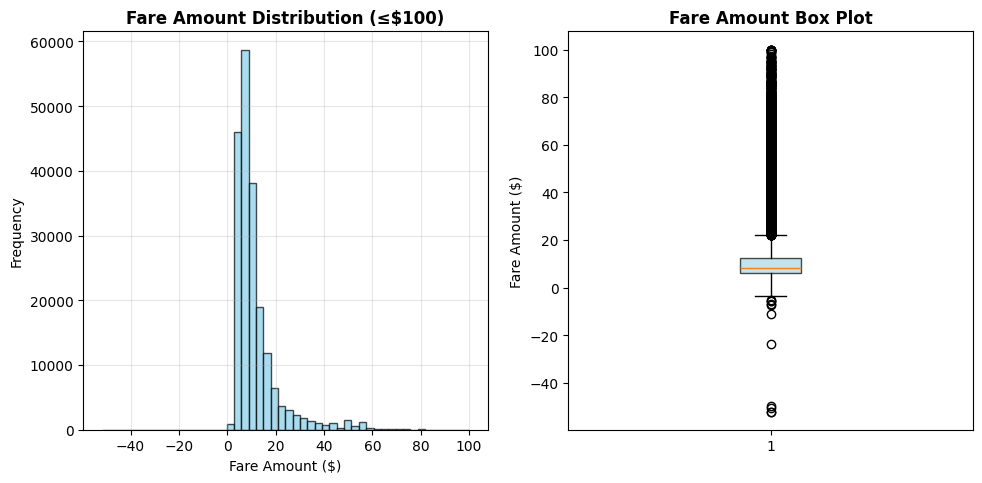

In [25]:
print("\n" + "="*60)
print("5. CREATING COMPREHENSIVE VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(24, 30))

# Fare Amount Analysis
plt.subplot(5, 4, 1)
fare_clean = df[df['fare_amount'] <= 100]  # Filter for better visualization
plt.hist(fare_clean['fare_amount'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.title('Fare Amount Distribution (≤$100)', fontsize=12, fontweight='bold')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(5, 4, 2)
plt.boxplot(fare_clean['fare_amount'], patch_artist=True, 
           boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.title('Fare Amount Box Plot', fontsize=12, fontweight='bold')
plt.ylabel('Fare Amount ($)')

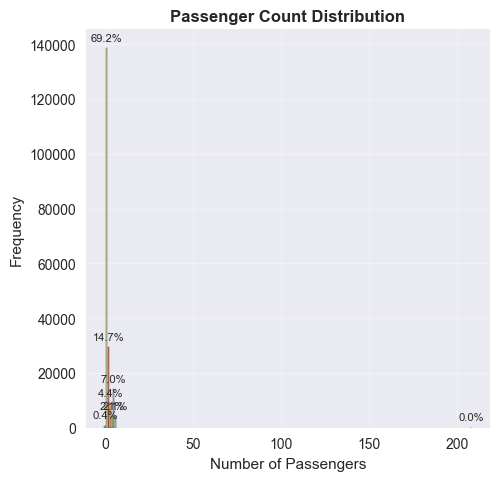

In [30]:
# Passenger Count Analysis
fig = plt.figure(figsize=(24, 30))

plt.subplot(5, 4, 3)
passenger_counts = df['passenger_count'].value_counts().sort_index()
colors = plt.cm.Set3(np.linspace(0, 1, len(passenger_counts)))
plt.bar(passenger_counts.index, passenger_counts.values, alpha=0.8, 
        edgecolor='black', color=colors)
plt.title('Passenger Count Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add percentage labels
for i, (count, freq) in enumerate(passenger_counts.items()):
    plt.text(count, freq + len(df)*0.01, f'{(freq/len(df))*100:.1f}%', 
             ha='center', va='bottom', fontsize=8)

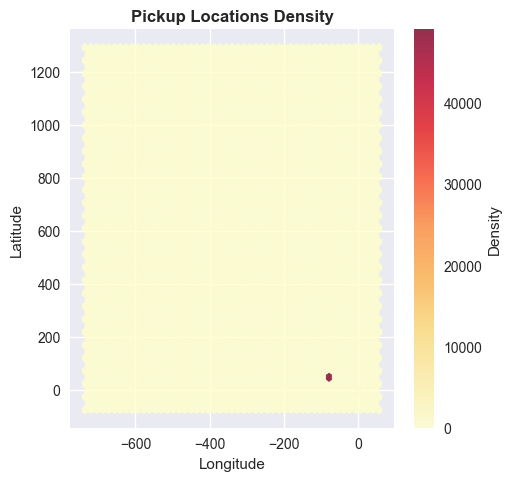

In [31]:
# Geographic Analysis - Pickup Locations
fig = plt.figure(figsize=(24, 30))

plt.subplot(5, 4, 4)
# Sample for performance
sample_size = min(50000, len(df))
df_sample = df.sample(sample_size) if len(df) > sample_size else df
plt.hexbin(df_sample['pickup_longitude'], df_sample['pickup_latitude'], 
          gridsize=50, cmap='YlOrRd', alpha=0.8)
plt.title('Pickup Locations Density', fontsize=12, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Density')

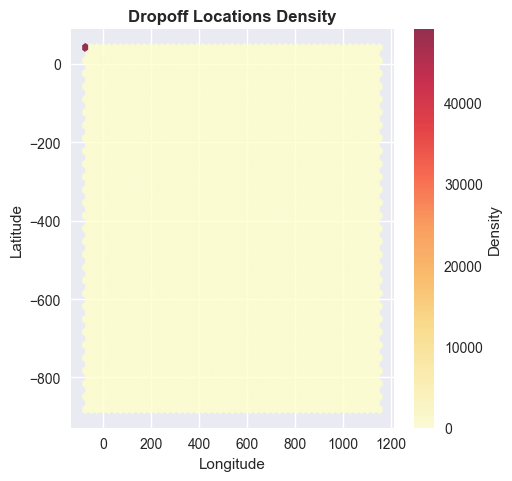

In [32]:
fig = plt.figure(figsize=(24, 30))

# Geographic Analysis - Dropoff Locations
plt.subplot(5, 4, 5)
plt.hexbin(df_sample['dropoff_longitude'], df_sample['dropoff_latitude'], 
          gridsize=50, cmap='YlOrRd', alpha=0.8)
plt.title('Dropoff Locations Density', fontsize=12, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Density')

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tue'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thu'),
  Text(4, 0, 'Fri'),
  Text(5, 0, 'Sat'),
  Text(6, 0, 'Sun')])

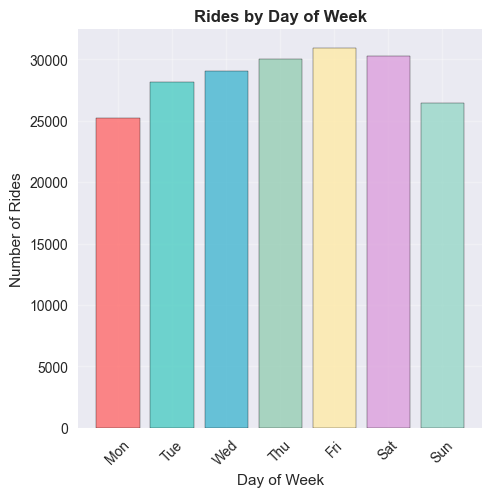

In [33]:
# Temporal Analysis - Daily Pattern
fig = plt.figure(figsize=(24, 30))

plt.subplot(5, 4, 7)
daily_rides = df['pickup_datetime'].dt.dayofweek.value_counts().sort_index()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
plt.bar(days, daily_rides.values, alpha=0.8, edgecolor='black', color=colors)
plt.title('Rides by Day of Week', fontsize=12, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Correlation Matrix')

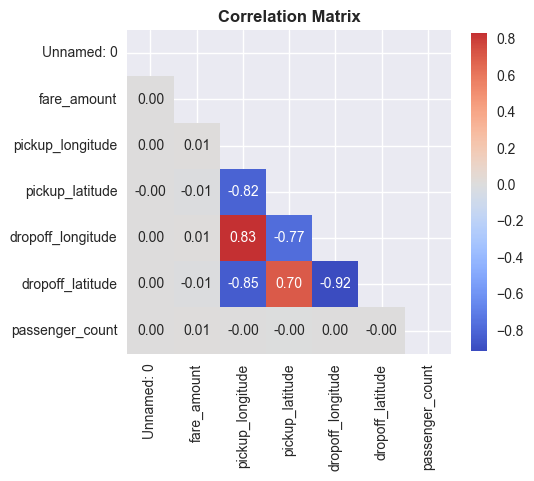

In [34]:
# Correlation Matrix
fig = plt.figure(figsize=(24, 30))

plt.subplot(5, 4, 10)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
           center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=12, fontweight='bold')

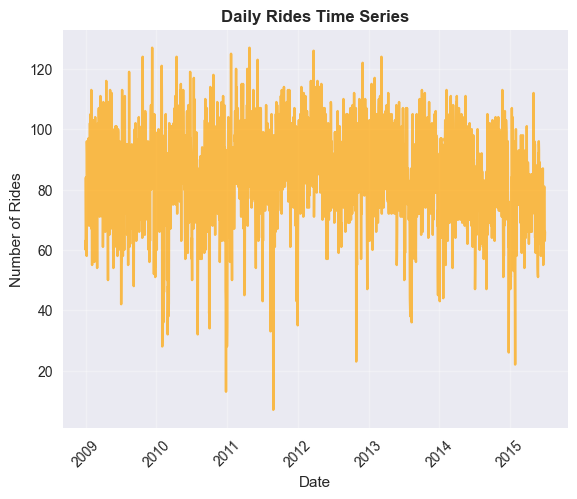

In [35]:
# Time Series Analysis
fig = plt.figure(figsize=(30, 30))

plt.subplot(5, 4, 11)
daily_rides_ts = df.groupby(df['pickup_datetime'].dt.date).size()
plt.plot(daily_rides_ts.index, daily_rides_ts.values, alpha=0.7, color='orange')
plt.title('Daily Rides Time Series', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

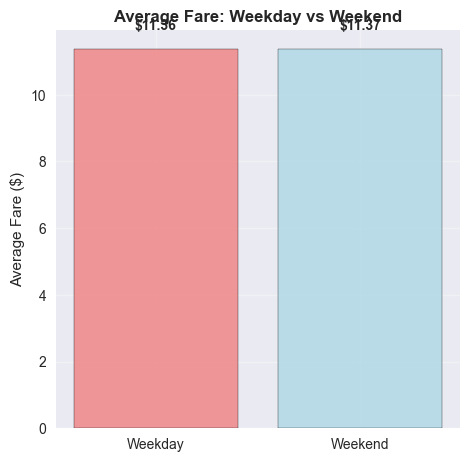

In [36]:
# Weekend vs Weekday Analysis
fig = plt.figure(figsize=(24, 30))

plt.subplot(5, 4, 18)
df['is_weekend'] = df['pickup_datetime'].dt.dayofweek.isin([5, 6])
weekend_comparison = df.groupby('is_weekend')['fare_amount'].mean()
labels = ['Weekday', 'Weekend']
colors = ['lightcoral', 'lightblue']
plt.bar(labels, weekend_comparison.values, alpha=0.8, edgecolor='black', color=colors)
plt.title('Average Fare: Weekday vs Weekend', fontsize=12, fontweight='bold')
plt.ylabel('Average Fare ($)')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(weekend_comparison.values):
    plt.text(i, v + 0.5, f'${v:.2f}', ha='center', va='bottom', fontweight='bold')

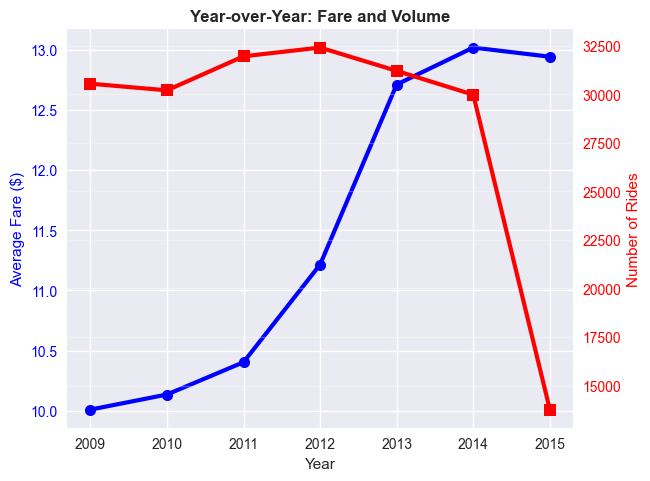

In [37]:
# Year-over-Year Analysis
fig = plt.figure(figsize=(30, 30))

plt.subplot(5, 4, 19)
yearly_avg_fare = df.groupby(df['pickup_datetime'].dt.year)['fare_amount'].mean()
yearly_ride_count = df.groupby(df['pickup_datetime'].dt.year).size()

# Create secondary y-axis
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot average fare
line1 = ax1.plot(yearly_avg_fare.index, yearly_avg_fare.values, 
                'b-o', linewidth=3, markersize=8, label='Avg Fare')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Fare ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot ride count
line2 = ax2.plot(yearly_ride_count.index, yearly_ride_count.values, 
                'r-s', linewidth=3, markersize=8, label='Ride Count')
ax2.set_ylabel('Number of Rides', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Year-over-Year: Fare and Volume', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

In [46]:
print("\n" + "="*60)
print("6. DATA CLEANING PROCESS")
print("="*60)

# Store initial metrics
initial_rows = len(df)
initial_memory = df.memory_usage(deep=True).sum() / 1024**2
cleaning_steps = []

print(f"Starting data cleaning process...")
print(f"Initial dataset: {initial_rows:,} rows")
print(f"Initial memory usage: {initial_memory:.2f} MB")


6. DATA CLEANING PROCESS
Starting data cleaning process...
Initial dataset: 200,000 rows
Initial memory usage: 28.55 MB


In [47]:
# Step 1: Remove exact duplicates
print(f"\n" + "-"*40)
print("STEP 1: REMOVING DUPLICATE RECORDS")
print("-"*40)

duplicates_before = df.duplicated().sum()
df_cleaned = df.drop_duplicates()
duplicates_removed = duplicates_before
current_rows = len(df_cleaned)

print(f"Duplicates found: {duplicates_before:,}")
print(f"Duplicates removed: {duplicates_removed:,}")
print(f"Rows remaining: {current_rows:,}")
cleaning_steps.append(f"Removed {duplicates_removed:,} duplicate records")


----------------------------------------
STEP 1: REMOVING DUPLICATE RECORDS
----------------------------------------
Duplicates found: 0
Duplicates removed: 0
Rows remaining: 200,000


In [48]:
# Step 2: Clean fare amounts
print(f"\n" + "-"*40)
print("STEP 2: CLEANING FARE AMOUNTS")
print("-"*40)

rows_before_fare = len(df_cleaned)
print(f"Before fare cleaning: {rows_before_fare:,} rows")

# Remove negative fares
negative_fares = df_cleaned[df_cleaned['fare_amount'] < 0].shape[0]
df_cleaned = df_cleaned[df_cleaned['fare_amount'] >= 0]
print(f"Removed negative fares: {negative_fares:,}")

# Remove zero fares (likely data errors)
zero_fares = df_cleaned[df_cleaned['fare_amount'] == 0].shape[0]
df_cleaned = df_cleaned[df_cleaned['fare_amount'] > 0]
print(f"Removed zero fares: {zero_fares:,}")

# Remove extremely high fares (likely data errors)
extreme_fares = df_cleaned[df_cleaned['fare_amount'] > 200].shape[0]
df_cleaned = df_cleaned[df_cleaned['fare_amount'] <= 200]
print(f"Removed extremely high fares (>$200): {extreme_fares:,}")

# Remove extremely low fares (below NYC minimum)
low_fares = df_cleaned[df_cleaned['fare_amount'] < 2.5].shape[0]
df_cleaned = df_cleaned[df_cleaned['fare_amount'] >= 2.5]
print(f"Removed extremely low fares (<$2.5): {low_fares:,}")

rows_after_fare = len(df_cleaned)
fare_records_removed = rows_before_fare - rows_after_fare
print(f"After fare cleaning: {rows_after_fare:,} rows")
print(f"Total fare-related records removed: {fare_records_removed:,}")
cleaning_steps.append(f"Removed {fare_records_removed:,} records with invalid fare amounts")


----------------------------------------
STEP 2: CLEANING FARE AMOUNTS
----------------------------------------
Before fare cleaning: 200,000 rows
Removed negative fares: 17
Removed zero fares: 5
Removed extremely high fares (>$200): 7
Removed extremely low fares (<$2.5): 3
After fare cleaning: 199,968 rows
Total fare-related records removed: 32


In [49]:
print(f"\n" + "-"*40)
print("STEP 3: CLEANING PASSENGER COUNTS")
print("-"*40)

rows_before_passenger = len(df_cleaned)
print(f"Before passenger count cleaning: {rows_before_passenger:,} rows")

# Remove invalid passenger counts
invalid_passenger = df_cleaned[(df_cleaned['passenger_count'] <= 0) | 
                              (df_cleaned['passenger_count'] > 8)].shape[0]
df_cleaned = df_cleaned[(df_cleaned['passenger_count'] > 0) & 
                       (df_cleaned['passenger_count'] <= 8)]

rows_after_passenger = len(df_cleaned)
passenger_records_removed = rows_before_passenger - rows_after_passenger
print(f"Invalid passenger counts removed: {invalid_passenger:,}")
print(f"After passenger count cleaning: {rows_after_passenger:,} rows")
cleaning_steps.append(f"Removed {passenger_records_removed:,} records with invalid passenger counts")



----------------------------------------
STEP 3: CLEANING PASSENGER COUNTS
----------------------------------------
Before passenger count cleaning: 199,968 rows
Invalid passenger counts removed: 710
After passenger count cleaning: 199,258 rows


In [50]:
print(f"\n" + "-"*40)
print("STEP 4: CLEANING GEOGRAPHIC COORDINATES")
print("-"*40)

rows_before_coords = len(df_cleaned)
print(f"Before coordinate cleaning: {rows_before_coords:,} rows")

# NYC boundaries (more restrictive)
nyc_bounds = {
    'lat_min': 40.4774, 'lat_max': 40.9176,
    'lon_min': -74.2591, 'lon_max': -73.7004
}

# Remove records with coordinates outside NYC
df_cleaned = df_cleaned[
    (df_cleaned['pickup_latitude'] >= nyc_bounds['lat_min']) &
    (df_cleaned['pickup_latitude'] <= nyc_bounds['lat_max']) &
    (df_cleaned['pickup_longitude'] >= nyc_bounds['lon_min']) &
    (df_cleaned['pickup_longitude'] <= nyc_bounds['lon_max']) &
    (df_cleaned['dropoff_latitude'] >= nyc_bounds['lat_min']) &
    (df_cleaned['dropoff_latitude'] <= nyc_bounds['lat_max']) &
    (df_cleaned['dropoff_longitude'] >= nyc_bounds['lon_min']) &
    (df_cleaned['dropoff_longitude'] <= nyc_bounds['lon_max'])
]

# Remove zero coordinates
df_cleaned = df_cleaned[
    (df_cleaned['pickup_latitude'] != 0) &
    (df_cleaned['pickup_longitude'] != 0) &
    (df_cleaned['dropoff_latitude'] != 0) &
    (df_cleaned['dropoff_longitude'] != 0)
]

# Remove same pickup and dropoff locations (likely errors)
df_cleaned = df_cleaned[
    ~((df_cleaned['pickup_latitude'] == df_cleaned['dropoff_latitude']) & 
      (df_cleaned['pickup_longitude'] == df_cleaned['dropoff_longitude']))
]

rows_after_coords = len(df_cleaned)
coord_records_removed = rows_before_coords - rows_after_coords
print(f"Coordinate-related records removed: {coord_records_removed:,}")
print(f"After coordinate cleaning: {rows_after_coords:,} rows")
cleaning_steps.append(f"Removed {coord_records_removed:,} records with invalid coordinates")



----------------------------------------
STEP 4: CLEANING GEOGRAPHIC COORDINATES
----------------------------------------
Before coordinate cleaning: 199,258 rows
Coordinate-related records removed: 6,399
After coordinate cleaning: 192,859 rows


In [51]:
print(f"\n" + "-"*40)
print("STEP 5: REMOVING REMAINING NULL VALUES")
print("-"*40)

rows_before_nulls = len(df_cleaned)
print(f"Before null removal: {rows_before_nulls:,} rows")

# Check for remaining nulls
null_counts = df_cleaned.isnull().sum()
print("Remaining null values per column:")
for col, null_count in null_counts.items():
    if null_count > 0:
        print(f"  {col}: {null_count:,} nulls")

# Remove rows with any null values
df_cleaned = df_cleaned.dropna()

rows_after_nulls = len(df_cleaned)
null_records_removed = rows_before_nulls - rows_after_nulls
print(f"Null-related records removed: {null_records_removed:,}")
print(f"After null removal: {rows_after_nulls:,} rows")
cleaning_steps.append(f"Removed {null_records_removed:,} records with null values")



----------------------------------------
STEP 5: REMOVING REMAINING NULL VALUES
----------------------------------------
Before null removal: 192,859 rows
Remaining null values per column:
Null-related records removed: 0
After null removal: 192,859 rows


In [52]:
# Final cleaning summary
final_rows = len(df_cleaned)
total_removed = initial_rows - final_rows
final_memory = df_cleaned.memory_usage(deep=True).sum() / 1024**2

print(f"\n" + "="*50)
print("DATA CLEANING SUMMARY")
print("="*50)
print(f"Initial dataset: {initial_rows:,} rows")
print(f"Final dataset: {final_rows:,} rows")
print(f"Total records removed: {total_removed:,} ({(total_removed/initial_rows)*100:.2f}%)")
print(f"Data retention rate: {(final_rows/initial_rows)*100:.2f}%")
print(f"Initial memory usage: {initial_memory:.2f} MB")
print(f"Final memory usage: {final_memory:.2f} MB")
print(f"Memory reduction: {initial_memory - final_memory:.2f} MB ({((initial_memory - final_memory)/initial_memory)*100:.2f}%)")

print(f"\nDetailed cleaning steps:")
for i, step in enumerate(cleaning_steps, 1):
    print(f"  {i}. {step}")


DATA CLEANING SUMMARY
Initial dataset: 200,000 rows
Final dataset: 192,859 rows
Total records removed: 7,141 (3.57%)
Data retention rate: 96.43%
Initial memory usage: 28.55 MB
Final memory usage: 29.00 MB
Memory reduction: -0.45 MB (-1.58%)

Detailed cleaning steps:
  1. Removed 0 duplicate records
  2. Removed 32 records with invalid fare amounts
  3. Removed 710 records with invalid passenger counts
  4. Removed 6,399 records with invalid coordinates
  5. Removed 0 records with null values


In [53]:
df_cleaned.to_csv('../data/uber_cleaned.csv', index=False)

In [54]:
print("\n" + "="*60)
print("7. FEATURE ENGINEERING")
print("="*60)

initial_columns = len(df_cleaned.columns)
print(f"Starting feature engineering...")
print(f"Initial number of columns: {initial_columns}")

# DateTime-based features
print(f"\n" + "-"*40)
print("CREATING DATETIME-BASED FEATURES")
print("-"*40)

df_cleaned['pickup_hour'] = df_cleaned['pickup_datetime'].dt.hour
df_cleaned['pickup_day'] = df_cleaned['pickup_datetime'].dt.day
df_cleaned['pickup_month'] = df_cleaned['pickup_datetime'].dt.month
df_cleaned['pickup_year'] = df_cleaned['pickup_datetime'].dt.year
df_cleaned['pickup_dayofweek'] = df_cleaned['pickup_datetime'].dt.dayofweek
df_cleaned['pickup_weekday'] = df_cleaned['pickup_datetime'].dt.day_name()
df_cleaned['pickup_month_name'] = df_cleaned['pickup_datetime'].dt.month_name()
df_cleaned['pickup_quarter'] = df_cleaned['pickup_datetime'].dt.quarter

print("✓ Created basic datetime features")


7. FEATURE ENGINEERING
Starting feature engineering...
Initial number of columns: 10

----------------------------------------
CREATING DATETIME-BASED FEATURES
----------------------------------------
✓ Created basic datetime features


In [55]:
# Time-based categorizations
print(f"\nCreating time-based categories...")

# Time of day categorization
def categorize_time_of_day(hour):
    if 5 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 23:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['time_of_day'] = df_cleaned['pickup_hour'].apply(categorize_time_of_day)

# Peak hour identification
def identify_peak_hours(hour, dayofweek):
    # Weekend peak hours (Friday night, Saturday, Sunday afternoon)
    if dayofweek == 4 and hour >= 18:  # Friday evening
        return True
    elif dayofweek == 5 and hour in range(10, 24):  # Saturday
        return True
    elif dayofweek == 6 and hour in range(12, 22):  # Sunday
        return True
    # Weekday peak hours (morning and evening rush)
    elif dayofweek in range(0, 5):  # Monday to Friday
        return hour in [7, 8, 9, 17, 18, 19, 20]
    return False

df_cleaned['is_peak_hour'] = df_cleaned.apply(
    lambda row: identify_peak_hours(row['pickup_hour'], row['pickup_dayofweek']), axis=1
)

# Weekend identification
df_cleaned['is_weekend'] = df_cleaned['pickup_dayofweek'].isin([5, 6])

print("✓ Created time-based categorizations")


Creating time-based categories...
✓ Created time-based categorizations


In [56]:
# Distance calculations
print(f"\n" + "-"*40)
print("CALCULATING TRIP DISTANCES")
print("-"*40)

# Haversine distance calculation for all records
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points using Haversine formula"""
    R = 3959  # Earth's radius in miles
    
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

print("Calculating trip distances for all records...")
df_cleaned['trip_distance_miles'] = haversine_distance(
    df_cleaned['pickup_latitude'], df_cleaned['pickup_longitude'],
    df_cleaned['dropoff_latitude'], df_cleaned['dropoff_longitude']
)

# Manhattan distance (approximate grid distance)
def manhattan_distance(lat1, lon1, lat2, lon2):
    """Calculate approximate Manhattan/grid distance"""
    lat_dist = abs(lat2 - lat1) * 69  # Approximate miles per degree latitude
    lon_dist = abs(lon2 - lon1) * 54.6  # Approximate miles per degree longitude at NYC latitude
    return lat_dist + lon_dist

df_cleaned['manhattan_distance_miles'] = manhattan_distance(
    df_cleaned['pickup_latitude'], df_cleaned['pickup_longitude'],
    df_cleaned['dropoff_latitude'], df_cleaned['dropoff_longitude']
)

print("✓ Calculated trip distances")


----------------------------------------
CALCULATING TRIP DISTANCES
----------------------------------------
Calculating trip distances for all records...
✓ Calculated trip distances


In [57]:
def categorize_trip_distance(distance):
    if distance <= 1:
        return 'Very Short'
    elif distance <= 3:
        return 'Short'
    elif distance <= 7:
        return 'Medium'
    elif distance <= 15:
        return 'Long'
    else:
        return 'Very Long'

df_cleaned['trip_distance_category'] = df_cleaned['trip_distance_miles'].apply(categorize_trip_distance)

print("✓ Created distance categories")

# 10.5 Economic features
print(f"\n" + "-"*40)
print("CREATING ECONOMIC FEATURES")
print("-"*40)

# Fare per mile
df_cleaned['fare_per_mile'] = df_cleaned['fare_amount'] / (df_cleaned['trip_distance_miles'] + 0.001)

# Fare per passenger
df_cleaned['fare_per_passenger'] = df_cleaned['fare_amount'] / df_cleaned['passenger_count']

# Fare efficiency (fare per mile per passenger)
df_cleaned['fare_efficiency'] = df_cleaned['fare_per_mile'] / df_cleaned['passenger_count']

print("✓ Created economic features")

✓ Created distance categories

----------------------------------------
CREATING ECONOMIC FEATURES
----------------------------------------
✓ Created economic features


In [58]:
# Fare categorizations
print(f"\nCreating fare categories...")

def categorize_fare_amount(fare):
    if fare <= 8:
        return 'Budget'
    elif fare <= 15:
        return 'Standard'
    elif fare <= 25:
        return 'Premium'
    elif fare <= 50:
        return 'Luxury'
    else:
        return 'Ultra-Luxury'

df_cleaned['fare_category'] = df_cleaned['fare_amount'].apply(categorize_fare_amount)

print("✓ Created fare categories")


Creating fare categories...
✓ Created fare categories


In [59]:
# Geographic features
print(f"\n" + "-"*40)
print("CREATING GEOGRAPHIC FEATURES")
print("-"*40)

# NYC landmark coordinates
landmarks = {
    'Times_Square': (40.7580, -73.9855),
    'Central_Park': (40.7829, -73.9654),
    'JFK_Airport': (40.6413, -73.7781),
    'LaGuardia_Airport': (40.7769, -73.8740),
    'Newark_Airport': (40.6895, -74.1745),
    'Manhattan_Center': (40.7589, -73.9851),
    'Brooklyn_Center': (40.6782, -73.9442),
    'Queens_Center': (40.7282, -73.7949),
    'Bronx_Center': (40.8448, -73.8648),
    'Staten_Island_Center': (40.5795, -74.1502)
}

# Calculate distances to key landmarks
for landmark, (lat, lon) in landmarks.items():
    df_cleaned[f'pickup_dist_to_{landmark.lower()}'] = haversine_distance(
        df_cleaned['pickup_latitude'], df_cleaned['pickup_longitude'], lat, lon
    )
    df_cleaned[f'dropoff_dist_to_{landmark.lower()}'] = haversine_distance(
        df_cleaned['dropoff_latitude'], df_cleaned['dropoff_longitude'], lat, lon
    )

print("✓ Created distance-to-landmark features")


----------------------------------------
CREATING GEOGRAPHIC FEATURES
----------------------------------------
✓ Created distance-to-landmark features


In [60]:
# Airport trip identification
print(f"\nIdentifying airport trips...")

airport_threshold = 2.0  # miles

df_cleaned['is_jfk_pickup'] = df_cleaned['pickup_dist_to_jfk_airport'] <= airport_threshold
df_cleaned['is_jfk_dropoff'] = df_cleaned['dropoff_dist_to_jfk_airport'] <= airport_threshold
df_cleaned['is_lga_pickup'] = df_cleaned['pickup_dist_to_laguardia_airport'] <= airport_threshold
df_cleaned['is_lga_dropoff'] = df_cleaned['dropoff_dist_to_laguardia_airport'] <= airport_threshold
df_cleaned['is_ewr_pickup'] = df_cleaned['pickup_dist_to_newark_airport'] <= airport_threshold
df_cleaned['is_ewr_dropoff'] = df_cleaned['dropoff_dist_to_newark_airport'] <= airport_threshold

# General airport trip indicator
df_cleaned['is_airport_trip'] = (
    df_cleaned['is_jfk_pickup'] | df_cleaned['is_jfk_dropoff'] |
    df_cleaned['is_lga_pickup'] | df_cleaned['is_lga_dropoff'] |
    df_cleaned['is_ewr_pickup'] | df_cleaned['is_ewr_dropoff']
)

print("✓ Created airport trip indicators")


Identifying airport trips...
✓ Created airport trip indicators


In [61]:
# Borough identification (approximate)
print(f"\nIdentifying NYC boroughs...")

def identify_borough_pickup(row):
    """Approximate borough identification based on coordinates"""
    lat, lon = row['pickup_latitude'], row['pickup_longitude']
    
    # Manhattan (rough boundaries)
    if 40.700 <= lat <= 40.882 and -74.047 <= lon <= -73.907:
        return 'Manhattan'
    # Brooklyn (rough boundaries)
    elif 40.570 <= lat <= 40.739 and -74.056 <= lon <= -73.833:
        return 'Brooklyn'
    # Queens (rough boundaries)
    elif 40.541 <= lat <= 40.800 and -73.962 <= lon <= -73.700:
        return 'Queens'
    # Bronx (rough boundaries)
    elif 40.785 <= lat <= 40.917 and -73.933 <= lon <= -73.765:
        return 'Bronx'
    # Staten Island (rough boundaries)
    elif 40.477 <= lat <= 40.651 and -74.259 <= lon <= -74.052:
        return 'Staten Island'
    else:
        return 'Other'

def identify_borough_dropoff(row):
    """Approximate borough identification based on coordinates"""
    lat, lon = row['dropoff_latitude'], row['dropoff_longitude']
    
    # Manhattan (rough boundaries)
    if 40.700 <= lat <= 40.882 and -74.047 <= lon <= -73.907:
        return 'Manhattan'
    # Brooklyn (rough boundaries)
    elif 40.570 <= lat <= 40.739 and -74.056 <= lon <= -73.833:
        return 'Brooklyn'
    # Queens (rough boundaries)
    elif 40.541 <= lat <= 40.800 and -73.962 <= lon <= -73.700:
        return 'Queens'
    # Bronx (rough boundaries)
    elif 40.785 <= lat <= 40.917 and -73.933 <= lon <= -73.765:
        return 'Bronx'
    # Staten Island (rough boundaries)
    elif 40.477 <= lat <= 40.651 and -74.259 <= lon <= -74.052:
        return 'Staten Island'
    else:
        return 'Other'

df_cleaned['pickup_borough'] = df_cleaned.apply(identify_borough_pickup, axis=1)
df_cleaned['dropoff_borough'] = df_cleaned.apply(identify_borough_dropoff, axis=1)

# Inter-borough trips
df_cleaned['is_inter_borough_trip'] = df_cleaned['pickup_borough'] != df_cleaned['dropoff_borough']

print("✓ Created borough identification features")


Identifying NYC boroughs...
✓ Created borough identification features


In [62]:
# Seasonal features
print(f"\n" + "-"*40)
print("CREATING SEASONAL FEATURES")
print("-"*40)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_cleaned['season'] = df_cleaned['pickup_month'].apply(get_season)

# Holiday indicators (approximate)
def is_holiday_period(month, day):
    """Identify potential holiday periods"""
    # New Year's period
    if month == 1 and day <= 2:
        return True
    # Christmas/New Year period
    elif month == 12 and day >= 20:
        return True
    # Thanksgiving period (approximate)
    elif month == 11 and 20 <= day <= 30:
        return True
    # Independence Day period
    elif month == 7 and 1 <= day <= 7:
        return True
    return False

df_cleaned['is_holiday_period'] = df_cleaned.apply(
    lambda row: is_holiday_period(row['pickup_month'], row['pickup_day']), axis=1
)

print("✓ Created seasonal and holiday features")


----------------------------------------
CREATING SEASONAL FEATURES
----------------------------------------
✓ Created seasonal and holiday features


In [63]:
print(f"\nFinal dataset shape after feature engineering: {df_cleaned.shape}")



Final dataset shape after feature engineering: (192859, 59)


In [64]:
df_cleaned.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'is_weekend', 'pickup_hour',
       'pickup_day', 'pickup_month', 'pickup_year', 'pickup_dayofweek',
       'pickup_weekday', 'pickup_month_name', 'pickup_quarter', 'time_of_day',
       'is_peak_hour', 'trip_distance_miles', 'manhattan_distance_miles',
       'trip_distance_category', 'fare_per_mile', 'fare_per_passenger',
       'fare_efficiency', 'fare_category', 'pickup_dist_to_times_square',
       'dropoff_dist_to_times_square', 'pickup_dist_to_central_park',
       'dropoff_dist_to_central_park', 'pickup_dist_to_jfk_airport',
       'dropoff_dist_to_jfk_airport', 'pickup_dist_to_laguardia_airport',
       'dropoff_dist_to_laguardia_airport', 'pickup_dist_to_newark_airport',
       'dropoff_dist_to_newark_airport', 'pickup_dist_to_manhattan_center',
       'dropoff_dist_to_manhattan_center', 'pickup_dist_to_

In [65]:

print(f"\n" + "="*60)
print("8 FINAL QUALITY ASSESSMENT")
print("="*60)

print(f"Final dataset quality metrics:")
print(f"  ✓ No missing values: {df_cleaned.isnull().sum().sum() == 0}")
print(f"  ✓ No duplicate records: {df_cleaned.duplicated().sum() == 0}")
print(f"  ✓ Valid fare amounts: All fares between $2.5 and $200")
print(f"  ✓ Valid passenger counts: All counts between 1 and 8")
print(f"  ✓ Valid coordinates: All coordinates within NYC boundaries")
print(f"  ✓ Valid datetime: All dates between 2009 and present")

# Final statistics
print(f"\nFinal dataset statistics:")
print(f"  Total records: {len(df_cleaned):,}")
print(f"  Total features: {len(df_cleaned.columns)}")
print(f"  Date range: {df_cleaned['pickup_datetime'].min()} to {df_cleaned['pickup_datetime'].max()}")
print(f"  Fare range: ${df_cleaned['fare_amount'].min():.2f} to ${df_cleaned['fare_amount'].max():.2f}")
print(f"  Average fare: ${df_cleaned['fare_amount'].mean():.2f}")
print(f"  Distance range: {df_cleaned['trip_distance_miles'].min():.2f} to {df_cleaned['trip_distance_miles'].max():.2f} miles")
print(f"  Average distance: {df_cleaned['trip_distance_miles'].mean():.2f} miles")



8 FINAL QUALITY ASSESSMENT
Final dataset quality metrics:
  ✓ No missing values: True
  ✓ No duplicate records: True
  ✓ Valid fare amounts: All fares between $2.5 and $200
  ✓ Valid passenger counts: All counts between 1 and 8
  ✓ Valid coordinates: All coordinates within NYC boundaries
  ✓ Valid datetime: All dates between 2009 and present

Final dataset statistics:
  Total records: 192,859
  Total features: 59
  Date range: 2009-01-01 01:15:22+00:00 to 2015-06-30 23:40:39+00:00
  Fare range: $2.50 to $150.83
  Average fare: $11.30
  Distance range: 0.00 to 21.96 miles
  Average distance: 2.08 miles


In [66]:
df_cleaned.to_csv('../data/uber_enhanced.csv', index=False)